# 4D-STEM Data Processing: *Large FOV Tungsten Selenide – Ripple*

In [234]:
"""Import the python script containing the helper functions and classes"""
from proc4D import *

---

## 1. Data Loading and Preprocessing

### 1.1. (Optional) Simulate 4D-STEM Data

### 1.1.1. Use model of a deformed surface

We begin by modeling a **geometric ripple**, which is a common formation in lateral heterojunctions of materials with significant lattice mismatch.

In [1]:
# Load the ripple model and abTEM helper functions
from rippleModel import * # ripple, calculate_surface_tilt, phplot

In [503]:
# Run this to see the docstring describing the influence of each of the model's parameters.
ripple?

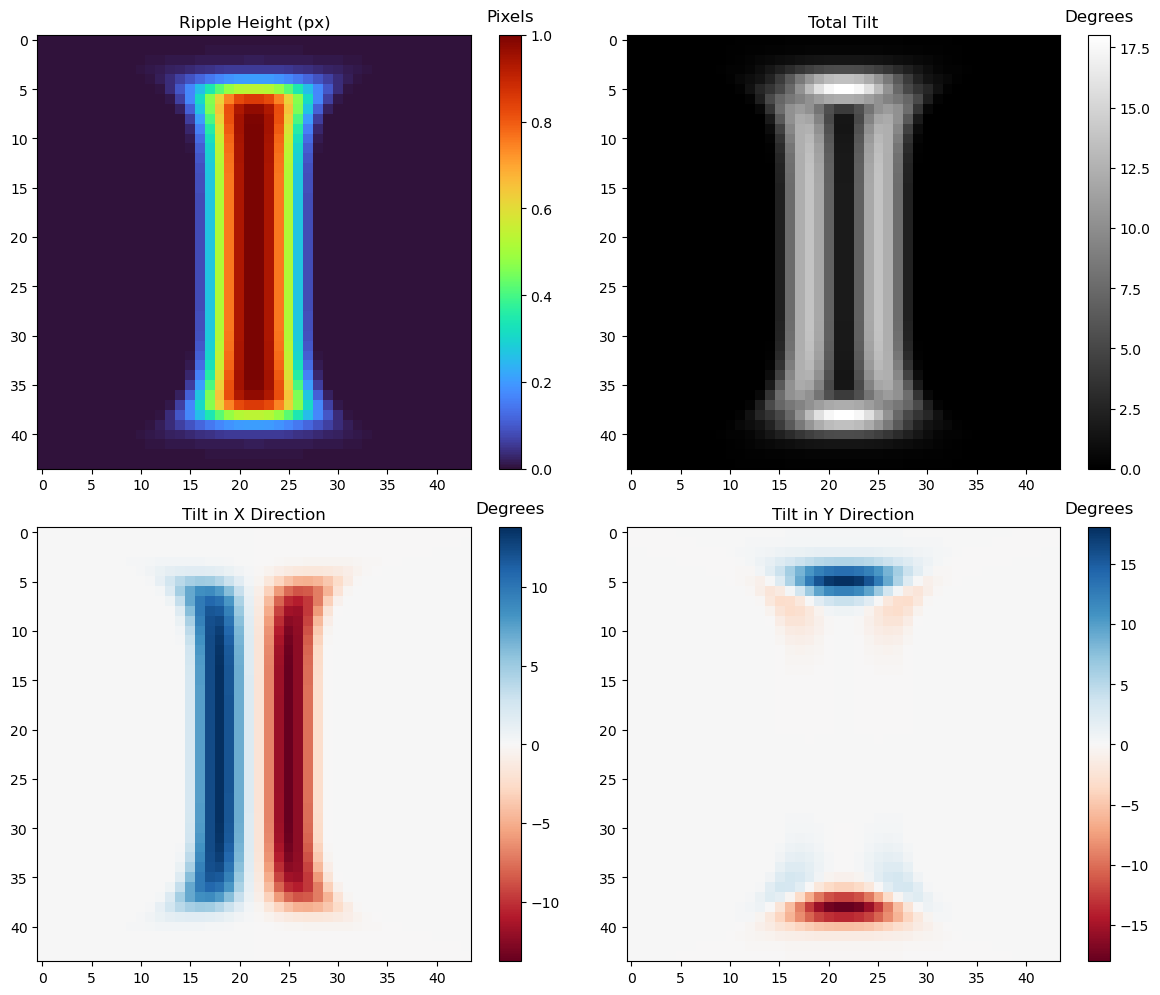

In [2]:
# Run the ripple model to visualize it

ripple_map = ripple(t=3.5, n=25, k=4.6, m=3, p=4.2, res=1, show_ripple_data=True, crop_size=None)

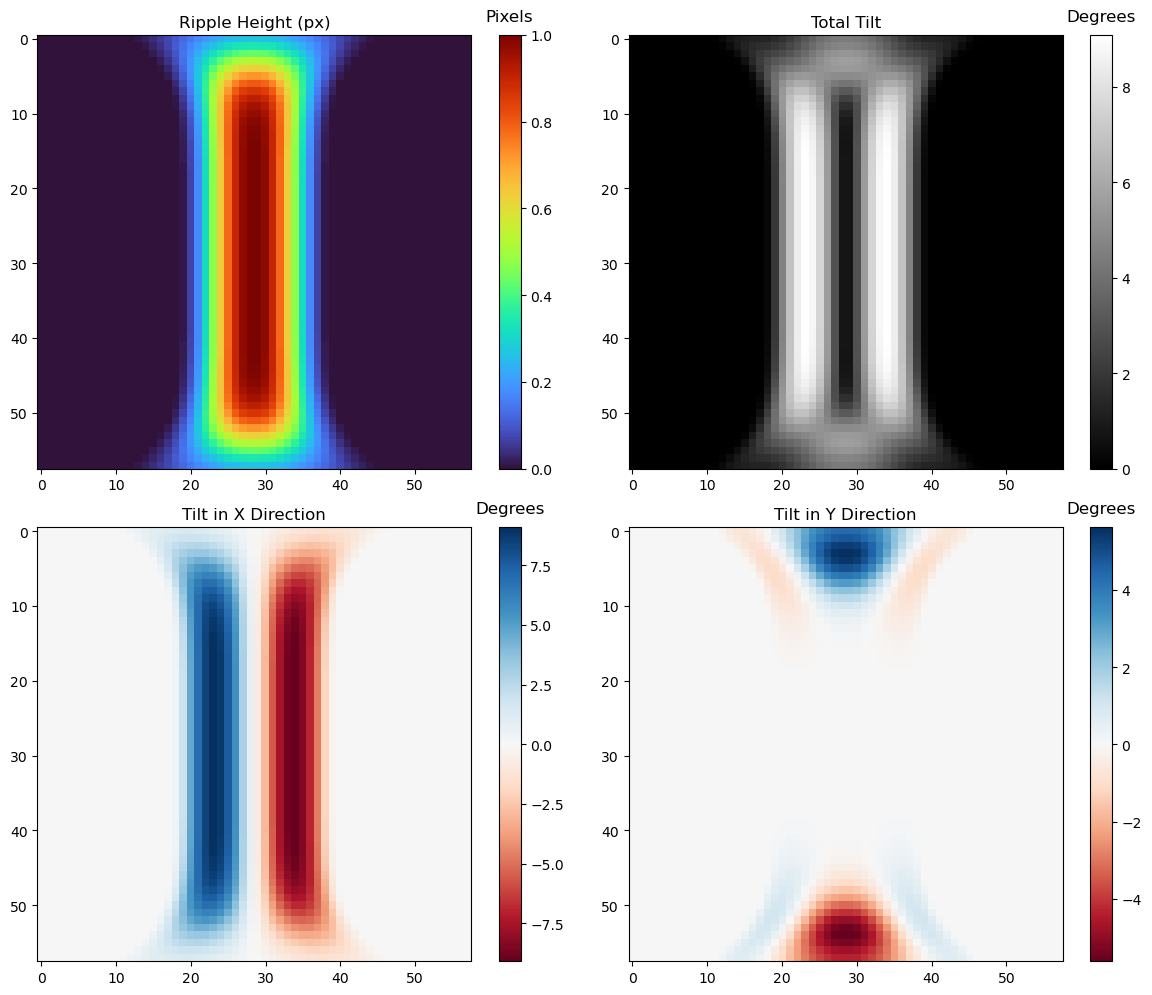

In [7]:
# Adjust parameters as desired. In this case we increase resolution 50%, crop a few pixels from the edges, and slightly 
# reduce the ripple's thickness.

ripple_map = ripple(t=3.5, n=10, k=4.6, m=2.9, p=4.2, res=1.5, show_ripple_data=True, crop_size=5)

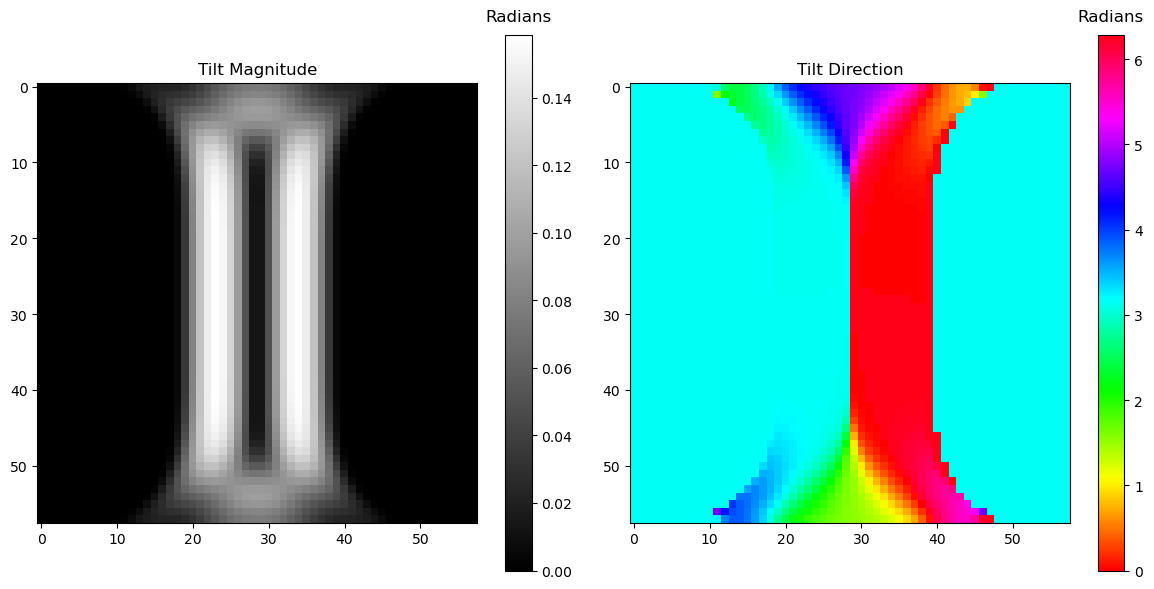

In [8]:
# We now collect the tilt and tilt-axis arrays from the simulated ripple array. This will serve to specify specific orientations
# for simulating diffraction patterns and obtaining a 4D dataset.

ripple_tilt, ripple_tilt_axis = calculate_surface_tilt(ripple_map, units='rad', show_results=True)

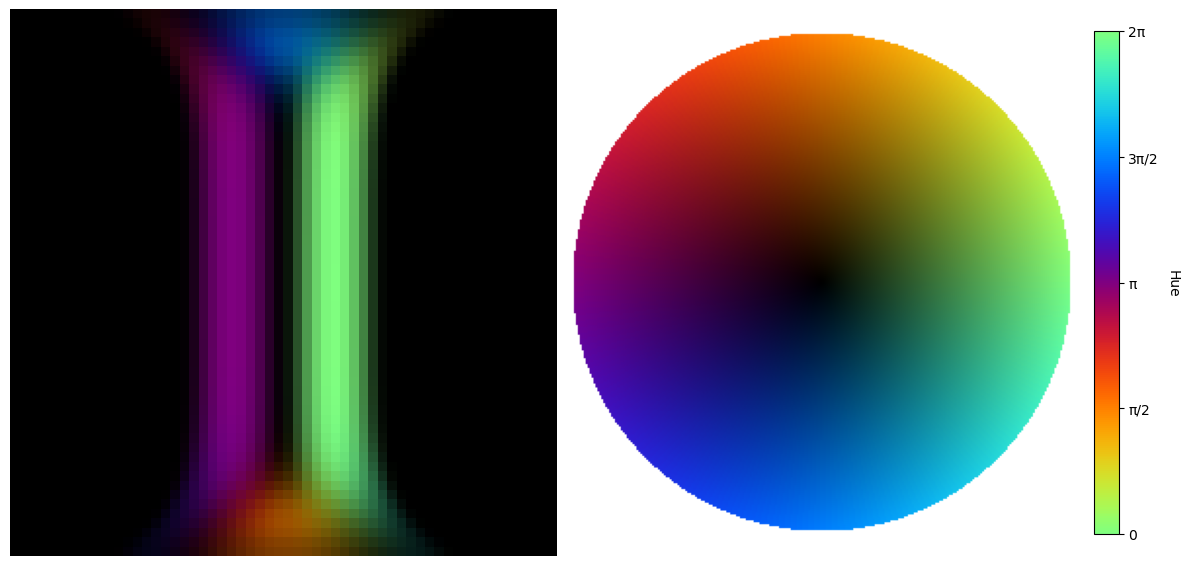

In [9]:
# Visualize a plot of combined amplitude and phase. 
phplot((ripple_tilt_axis, ripple_tilt), Amp='raw', scale=True, subplot=True);

In [10]:
ripple_tilt.shape

(58, 58)

### 1.1.2. Load WSe2 atomic model from *MaterialsProject*

In [235]:
from ase.io import read
from abtem import *
from abTEM_helpers import * # module containing abTEM wrapper functions

We download the .cif file of experimentally-verified $\text{WSe}_2$ from https://next-gen.materialsproject.org/materials/mp-1821?chemsys=W-Se. **Note** that this model is for bilayer $\text{WSe}_2$. To obtain the monolayer version, we used the software **VESTA** (https://jp-minerals.org/vesta/en/download.html) to modify the cell.

In [236]:
import os
import sys
os.chdir("C:/Users/haloe/Documents/CodeWriting/4Denoise/helpers")
import sys
sys.path.append("C:/Users/haloe/Documents/CodeWriting/4Denoise/")

os.getcwd()

'C:\\Users\\haloe\\Documents\\CodeWriting\\4Denoise\\helpers'

We may load the atomic model from **Materials Project** and create a lattice or skip to **Section 1.1.3** to directly load the lattice if the lattice is saved. 

In [13]:
# Load WSe2 atomic model from Materials Project (https://next-gen.materialsproject.org/)
atoms = read("./WSe2_mono.cif")

In [14]:
atoms

Atoms(symbols='WSe2', pbc=True, cell=[[3.319933, 0.0, 0.0], [-1.6599664999999992, 2.8751463168622826, 0.0], [0.0, 0.0, 6.868595]], spacegroup_kinds=...)

We need to **orthogonalize** the cell for the multislice method to work. See section titled "*Orthogonal and periodic supercells*" in https://abtem.readthedocs.io/en/latest/user_guide/tutorials/advanced_atomic_models.html.

Additional transformations:
Euler angles (degrees): 	 x = 0.000, 	 y = -0.000, 	 z = -0.000
Normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = 0.000
Shear strains (percent): 	 xy = -0.000, 	 xz = 0.000, 	 xz = 0.000


(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Side view of $WSe_2$ Lattice'}, xlabel='x [Å]', ylabel='z [Å]'>)

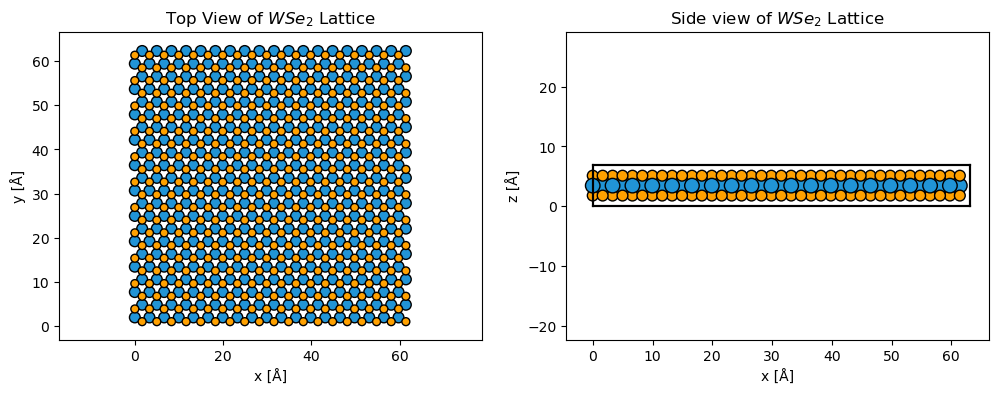

In [15]:
unit_cell_length = atoms.cell[0,0] # angstroms (alternatively, user can manually define the unit cell length)

# Define the scale of the ripple model in angstroms per pixel
scale = 25 # Ang/px

"""Repeat atom cell and orthogonalize it, as required by the multislice algorithm"""
atoms_orthogonalized, transform = orthogonalize_cell(atoms, return_transform=True)

from abtem.atoms import pretty_print_transform
print("Additional transformations:")
pretty_print_transform(transform)

repetitions = (round(2.5*scale/unit_cell_length), round(1.5*scale/unit_cell_length), 1)
wse2_lattice = atoms_orthogonalized*repetitions

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
show_atoms(wse2_lattice, ax=ax1, title=r'Top View of $WSe_2$ Lattice',show_cell=False)
show_atoms(wse2_lattice, ax=ax2, plane='xz', title=r'Side view of $WSe_2$ Lattice')

In [16]:
# (Optional) Save the lattice to avoid rerunning the above
wse2_lattice.write('wse2_lattice.cif', format='cif')

### 1.1.3. Test *abTEM* simulations of lattice 

Next, we define the variables $(\phi, \theta)$, where: 

* $\theta$ represents the **tilt** and 

* $\phi$ the **tilt axis** around which the tilt is measured from.

See figure below. These variables will be used to tilt the lattice and obtain the corresponding diffraction patterns.

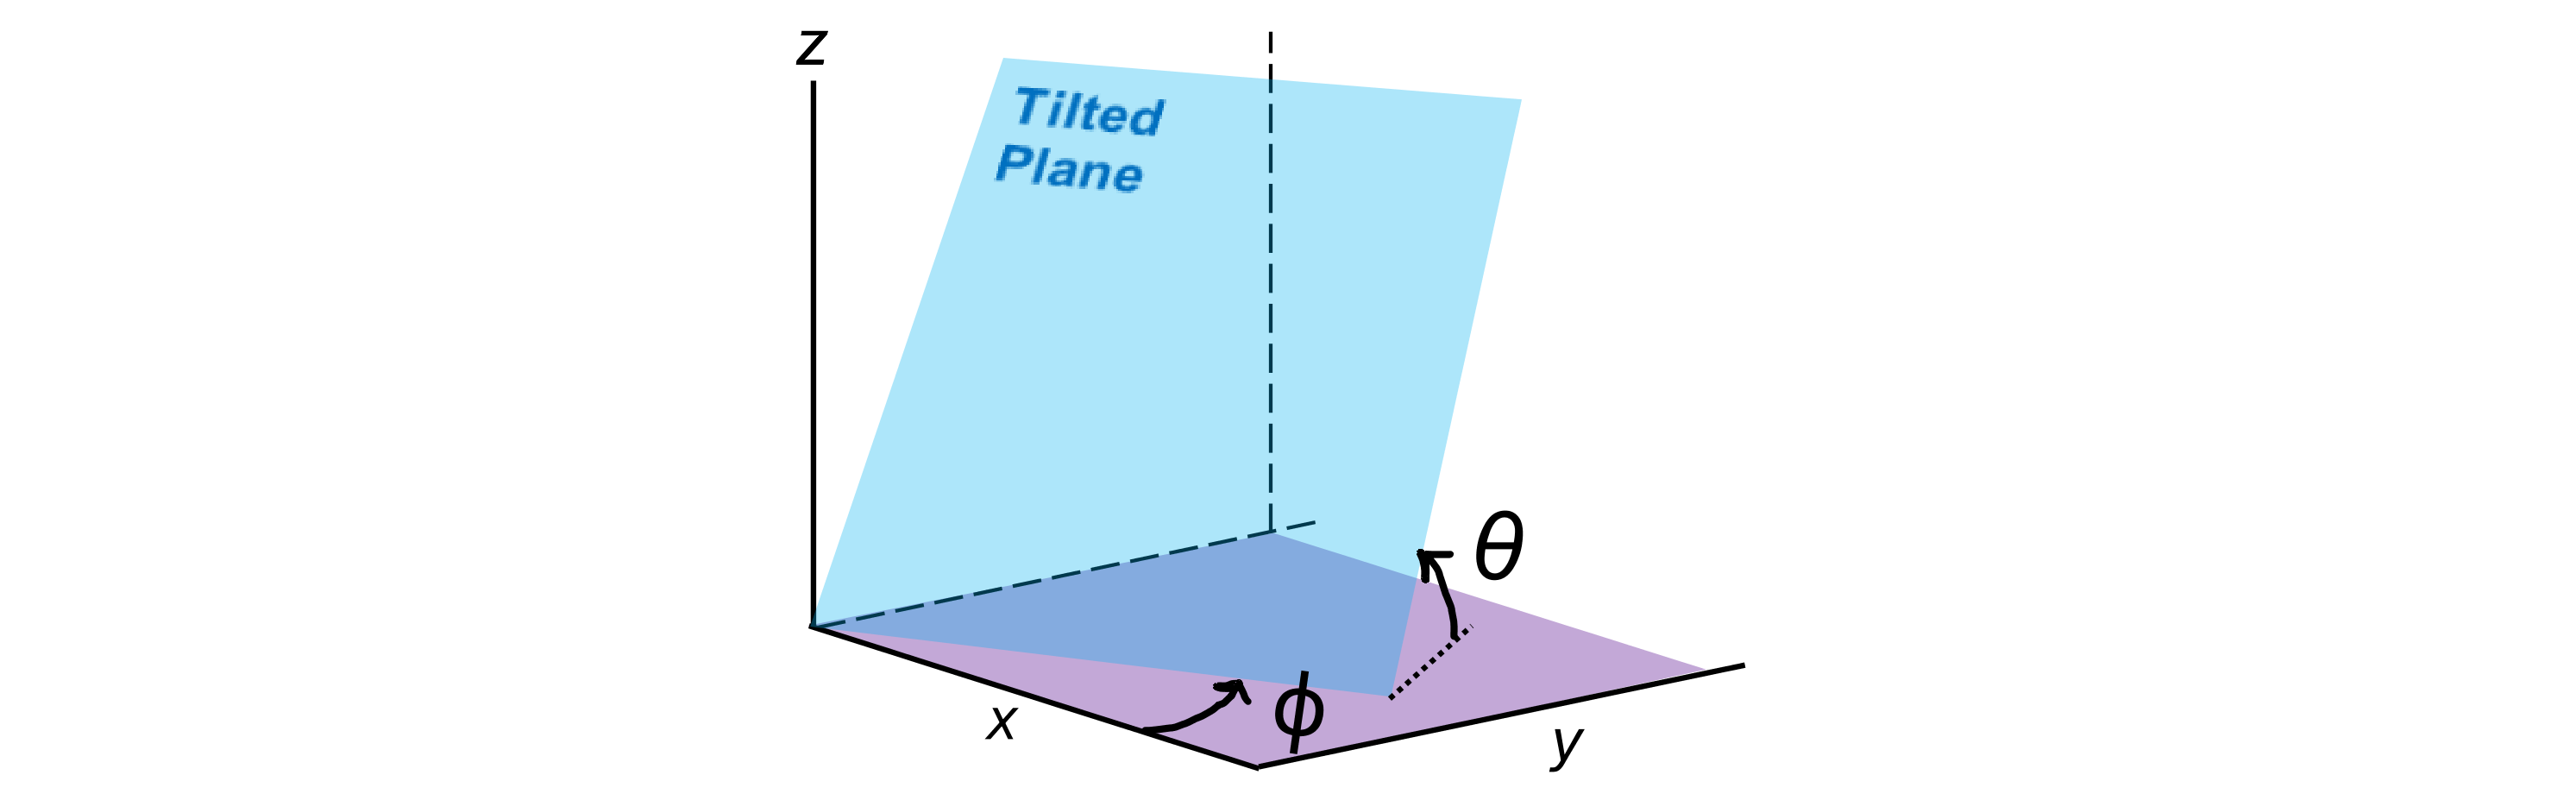

Test the tilt variables.

In [237]:
# (Optional) If the lattice was previously saved, simply load the atoms object running this cell
wse2_lattice = read('wse2_lattice.cif')

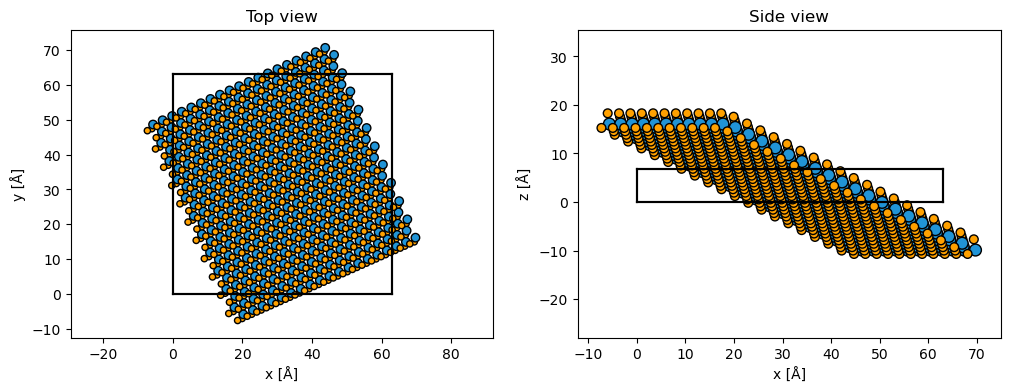

In [238]:
rot_lattice(wse2_lattice, theta_tilt=25, phi_rot=90, rotZ=24);

We visualize the diffraction patterns corresponding to the **flat** lattice (non-rotated nor tilted). 

[########################################] | 100% Completed |  0.1s
Probe FWHM = 13.552064895629883 Å
[                                        ] | 0% Completed |  0.0s

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


[########################################] | 100% Completed |  0.7s


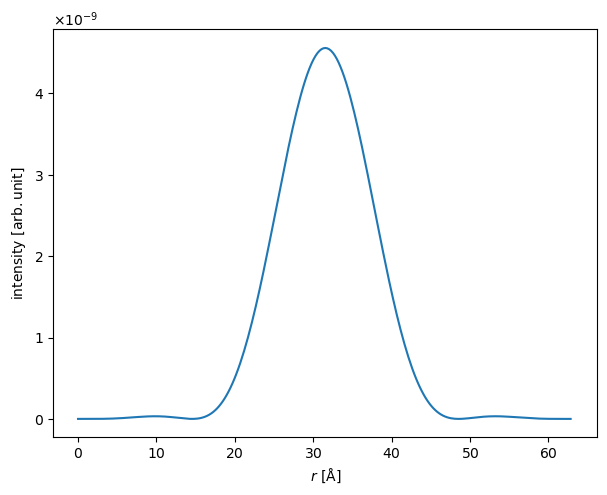

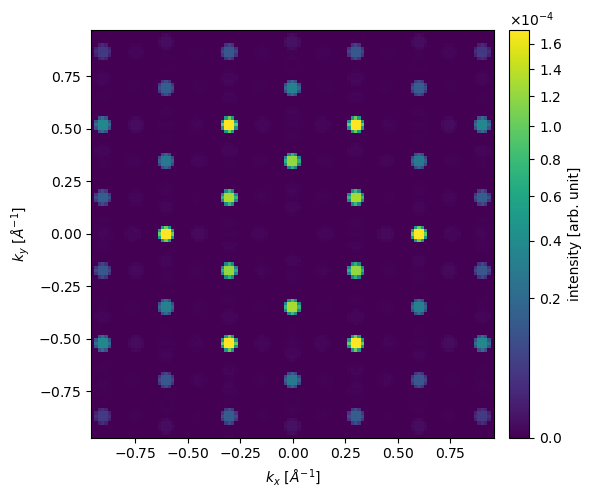

In [239]:
# We visualize the probe shape and the diffraction pattern (flat case)
flat_pattern = simulate_diff(wse2_lattice, theta_tilt=0, phi_rot=0, rotZ=0, energy=80e3, 
                      semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**8, device='gpu', max_angle=42, units='deg',get_probe_info=True,)


flat_pattern.block_direct().show(power=0.5, cbar=True,)

We now visualize a diffraction pattern when the sample is **tilted and rotated**. In addition, we compare this diffraction pattern when the atoms are perfectly **static** versus their **frozen phonon** counterpart by using the argument `frozen_phonons`. Note that the **mean** configuration is returned.

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")
C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


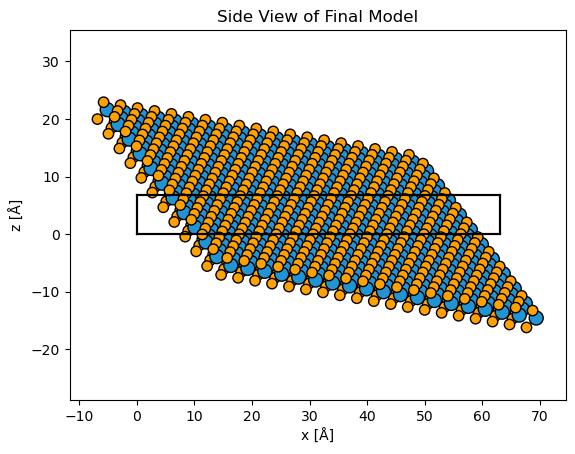

In [240]:
tilt_wse2_pattern = simulate_diff(wse2_lattice, theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
                      semiangle_cutoff=2.25, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=None, get_probe_info=False,show_model=True,
                      auto_crop=True)

tilt_wse2_phonon = simulate_diff(wse2_lattice, theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
                      semiangle_cutoff=2.25, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=None, get_probe_info=False,
                      frozen_phonons=True,num_configs=10,seed=round(1000*np.random.random()),sigmas=0.3,ensemble_mean=True,
                      auto_crop=True) # Frozen phonon arguments

In [241]:
tilt_wse2_pattern.shape

(171, 173)

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  1.4s


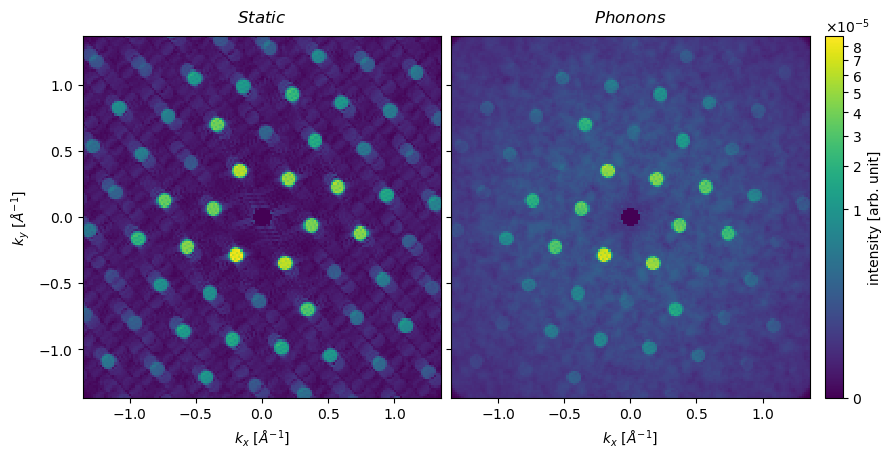

In [242]:
diffraction_patterns = stack(
                                [
                                tilt_wse2_pattern.compute().block_direct(),
                                tilt_wse2_phonon.compute().block_direct(),
                                ],
                                ("Static", "Phonons"),
                            )

diffraction_patterns.show(
                             explode=True,
                             power=0.3,
                             figsize=(10, 6),
                             cbar=True,
                             common_color_scale=True,
                         );

### 1.1.5. Amorphous Background Incorporation 

In this subsection, we will simulate an **amorphous silicon nitride** to include in the simulation of WSe2. We will achieve this by using a crystalline Si3N4 material and then randomly displacing the atoms relative to the Si-N bond length.

In [59]:
# Load and orthogonalize silicon nitride unit cell.
atoms_SiN = read('Si3N4.cif')
atoms_SiN = orthogonalize_cell(atoms_SiN)

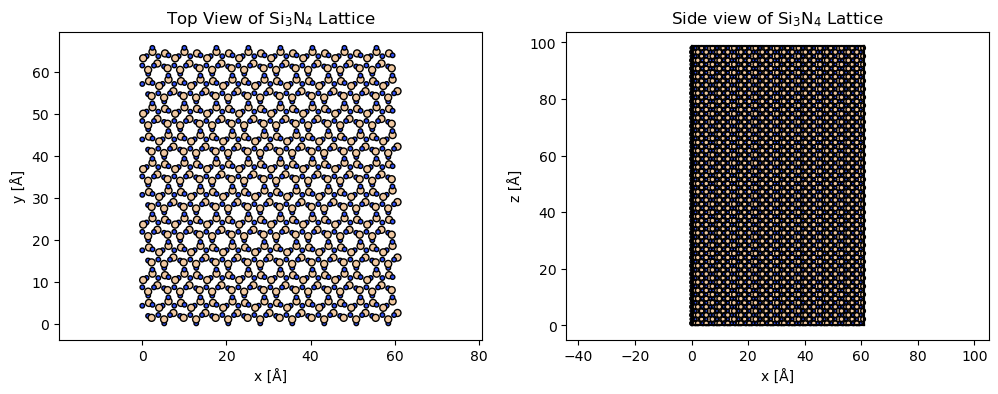

In [60]:
# Define required number of repetitions in xy directions
x_Reps, y_Reps, _ = np.round(np.sum(wse2_lattice.cell, axis = 0) / np.sum(atoms_SiN.cell, axis = 0)).astype(int)

amorphous_layer_thickness = 100 #Angstroms
z_Reps = np.round(amorphous_layer_thickness/atoms_SiN.cell[2,2]).astype(int)

siN_lattice = atoms_SiN*(x_Reps,y_Reps,z_Reps) 

show_atoms_top_and_side(siN_lattice, title1=r'Top View of Si$_3$N$_4$ Lattice',title2=r'Side view of Si$_3$N$_4$ Lattice')

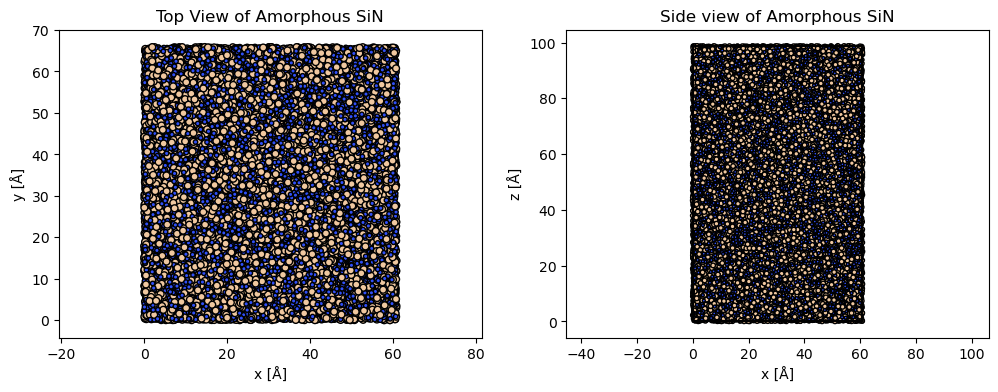

In [61]:
bondLength_SiN = 1.735  # Si-N bond length
std_displacement_fraction = 3

rng = np.random.default_rng(seed=round(1e3*np.random.random()))
amorphous_SiN = siN_lattice.copy()
amorphous_SiN.positions[:] += rng.normal(size=(len(amorphous_SiN), 3)) * std_displacement_fraction * bondLength_SiN

# Wrap the atoms displaced outside the cell back into the cell
amorphous_SiN.wrap()
show_atoms_top_and_side(amorphous_SiN, title1='Top View of Amorphous SiN', title2='Side view of Amorphous SiN')

We now combine the WSe$_2$ model with the amorphous substrate, apply a desired tilt, and compare the result when applying thermal vibrations versus when not.

In [126]:
# Regenerate a randomized initial amorphous SiN cell
rng = np.random.default_rng(seed=round(1e3*np.random.random()))
amorphous_SiN = siN_lattice.copy()
amorphous_SiN.positions[:] += rng.normal(size=(len(amorphous_SiN), 3)) * std_displacement_fraction * bondLength_SiN

# Wrap the atoms displaced outside the cell back into the cell
amorphous_SiN.wrap()

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")
C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


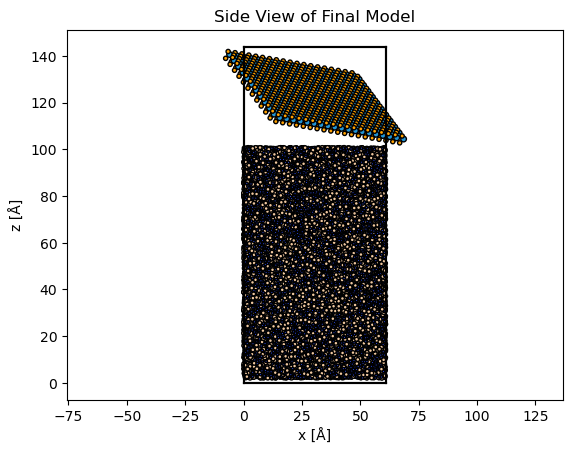

In [130]:
# Simulate static diffraction pattern
wse2_substrate_static = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
          theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
          semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
          sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=None, 
          get_probe_info=False,show_model=True,)

# Define the standard deviation of atomic displacements due to thermal vibrations for each species in material
sigmas = {
            'Si': bondLength_SiN*std_displacement_fraction,  
            'N': bondLength_SiN*std_displacement_fraction,   
            'W': 2.552*0.05, # 5% the bond length  
            'Se': 2.552*0.05, # 5% the bond length  
         }

# Simulate diffraction pattern using frozen phonon method
wse2_substrate_phonon = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
          theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
          semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
          sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=None, get_probe_info=False,show_model=False,
          frozen_phonons=True, num_configs=10, sigmas=sigmas, seed=1000*int(np.random.random()), ensemble_mean=True)

[########################################] | 100% Completed | 12.0s
[########################################] | 100% Completed | 34.9s


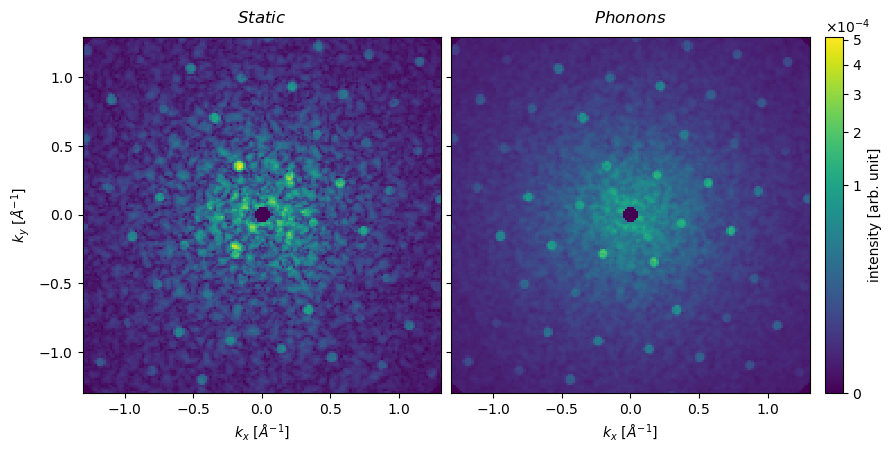

In [129]:
diffraction_patterns = stack(
                                [
                                wse2_substrate_static.compute().block_direct(),
                                wse2_substrate_phonon.compute().block_direct(),
                                ],
                                ("Static", "Phonons"),
                            )

diffraction_patterns.show(
                         explode=True,
                         power=0.33,
                         figsize=(10, 6),
                         cbar=True,
                         common_color_scale=True,
                         );

### 1.1.6. Poisson Noise Incorporation

Below, an array of shape (1, 2) is subjected to poisson noise and we obtain 5 samples from this array. Note that if we obtained the standard deviation from a high number of samples, it would converge to sqrt(50).

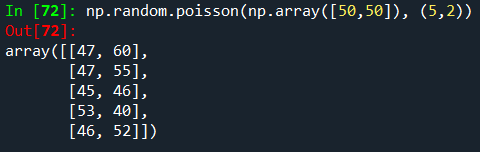

In [173]:
wse2_substrate_phonon = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
          theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
          semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
          sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=54, get_probe_info=False,show_model=False,
          frozen_phonons=True, num_configs=10, sigmas=sigmas, seed=1000*int(np.random.random()), ensemble_mean=True, auto_crop=False)

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


In [174]:
counts = 2e5
flat_pattern_noisy = ReciprocalSection(np.rot90(add_poisson_noise(wse2_substrate_phonon.compute().array, counts)))

[########################################] | 100% Completed | 43.9s


In [176]:
wse2_substrate_phonon.shape

(159, 173)

In [177]:
angles = wse2_substrate_phonon.max_angles
max_angle, min_angle = [np.max(angles), np.min(angles)]

In [182]:
angles

(54.2244132875795, 54.528754355606765)

In [181]:
max_angle/min_angle*159

159.8924067017507

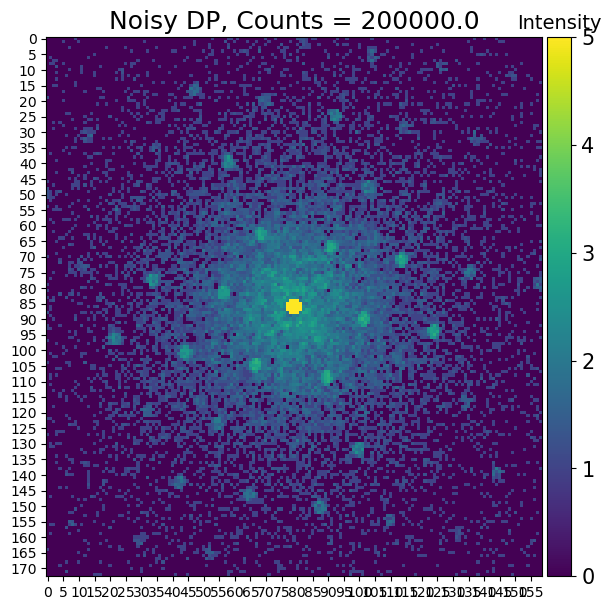

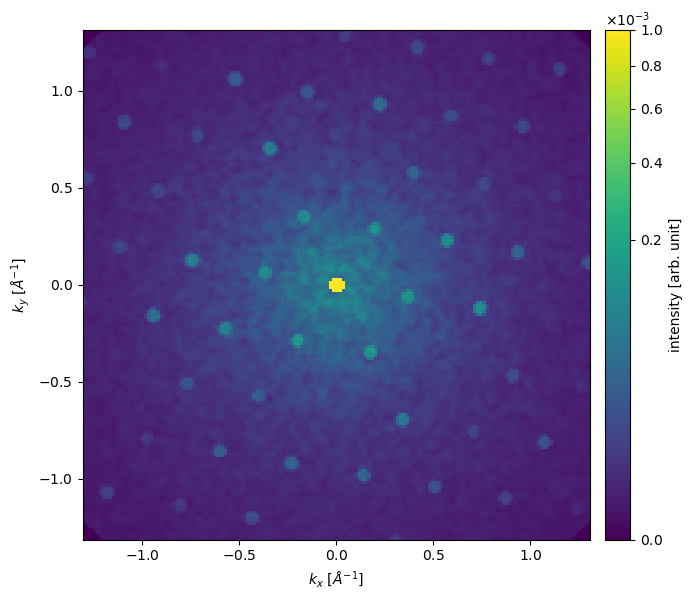

In [175]:
flat_pattern_noisy.show(power=0.33,
                        logScale=False,
                        figsize=(12, 7),
                        cmap='viridis',
                        vmax = 5,
                        title = f'Noisy DP, Counts = {counts}' 
                        );

wse2_substrate_phonon.show(
                             power=0.33,
                             figsize=(10, 6),
                             cbar=True,
                             common_color_scale=True,
                             vmax= 1e-3
                         );

Compare ideal (phonon) with noisy.

In [40]:
def rand_val(min_val, max_val):
    val_range = max_val - min_val
    return np.random.random()*val_range + min_val

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")
C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


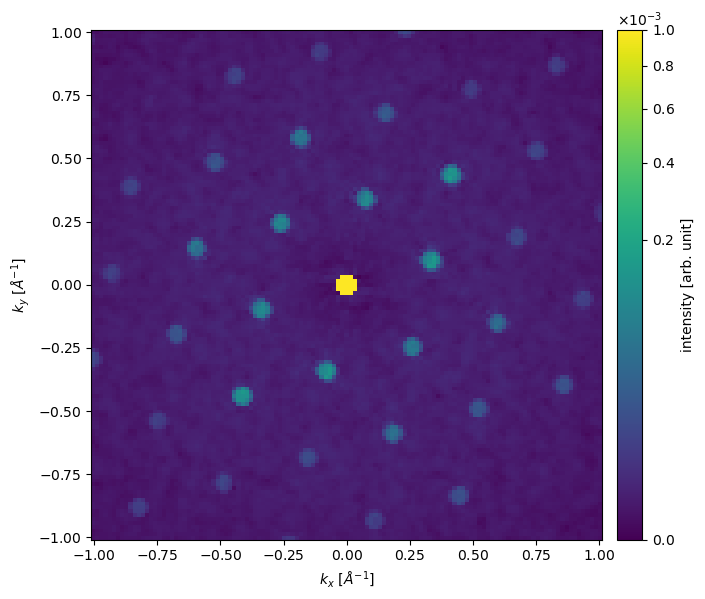

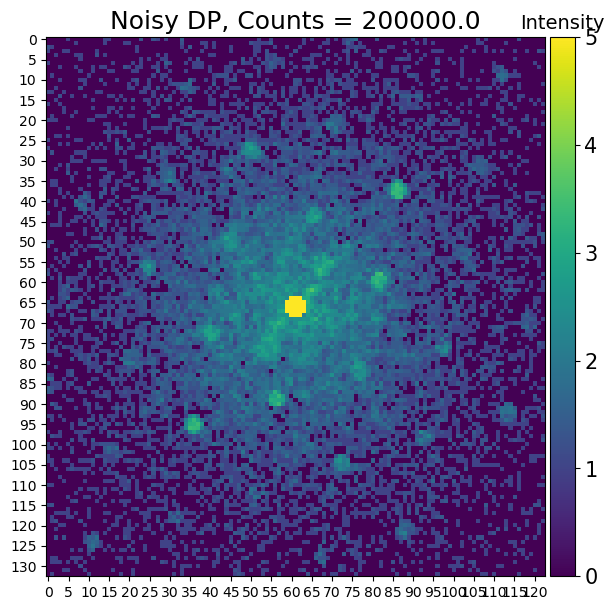

In [106]:
# Test random orientation of 2D material
theta = rand_val(0,30)
phi = rand_val(0,360)
Z = rand_val(0,360)


tilt_wse2_phonon = simulate_diff(wse2_lattice, theta_tilt=theta, phi_rot=phi, rotZ=Z, 
                                 units='deg', energy=80e3, 
                      semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=42, 
                      max_frequency=1, get_probe_info=False,
                      frozen_phonons=True,num_configs=10,seed=150,sigmas=0.3,ensemble_mean=True) # Frozen phonon arguments

tilt_wse2_phonon.show(
                         explode=True,
                         power=0.33,
                         figsize=(10, 6),
                         cbar=True,
                        vmax=0.001

                         );

wse2_substrate_phonon = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
          theta_tilt=theta, phi_rot=phi, rotZ=Z, units='deg', energy=80e3, 
          semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
          sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=42, 
          max_frequency=1, get_probe_info=False,show_model=False,
          frozen_phonons=True, num_configs=8, sigmas=sigmas, seed=1000*int(np.random.random()), ensemble_mean=True)

# tilt_wse2_pattern = simulate_diff(atom_model=wse2_lattice, substrate=None, interlayer_dist=2,vacuum=2,
#           theta_tilt=theta, phi_rot=phi, rotZ=Z, units='deg', energy=80e3, 
#           semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
#           sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=42, 
#           max_frequency=1, get_probe_info=False,show_model=False,
#           frozen_phonons=False, num_configs=8, sigmas=sigmas, seed=1000*int(np.random.random()), ensemble_mean=True)

# tilt_wse2_pattern.show(
#                          explode=True,
#                          power=0.33,
#                          figsize=(10, 6),
#                          cbar=True,
#                         vmax=0.001
#                          );


counts = 2e5
wse2_substrate_phonon_noisy = ReciprocalSection(np.rot90(add_poisson_noise(wse2_substrate_phonon.array, counts)))

wse2_substrate_phonon_noisy.show(power=0.33,
                                logScale=False,
                                 figsize=(12, 7),
                                 cmap='viridis',
                                 vmax = 5,
                                 title = f'Noisy DP, Counts = {counts}' 
                                 );

### 1.1.7. Obtain Simulated 4D Dataset 

Since we are assuming we have a  fully symmetric ripple, we will simulate only a quarter of it.

In [49]:
# Note that we multiply the height below by 3 to increase the tilt (see next cell)
ripple_map = 3*ripple(t=3.5, n=10, k=4.6, m=2.9, p=4.2, res=2, show_ripple_data=False, crop_size=2, return_full_ripple=False)

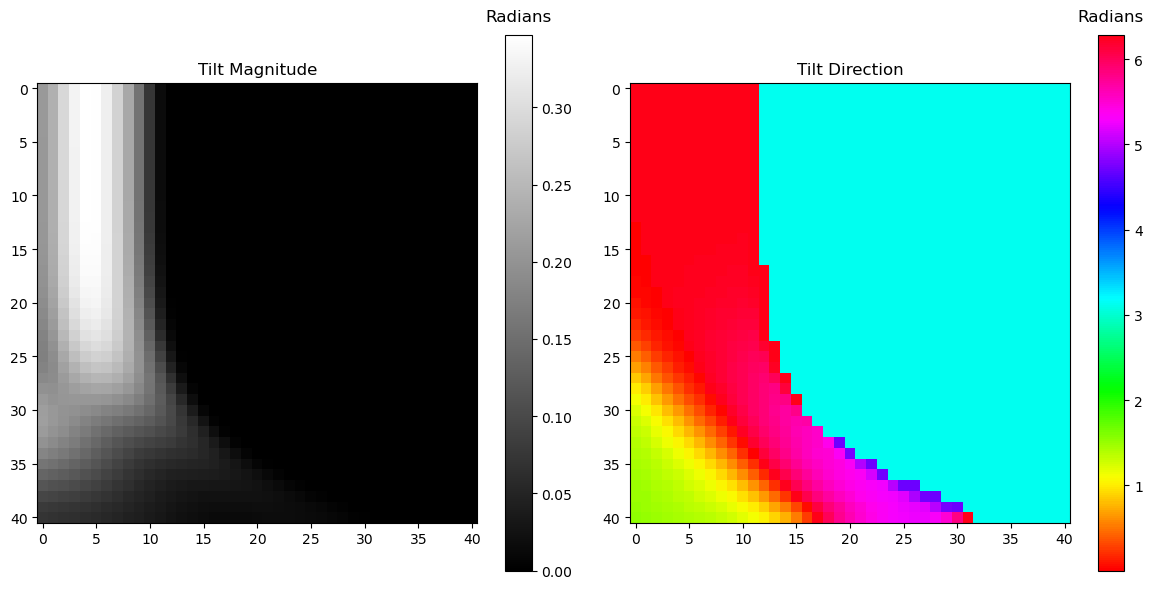

C:\Users\haloe\Documents\CodeWriting\4Denoise\helpers\rippleModel.py:293: RuntimeWarning: invalid value encountered in cast
  idx = np.clip(((hue + np.pi) / (2 * np.pi) * 255).astype(int), 0, 255)


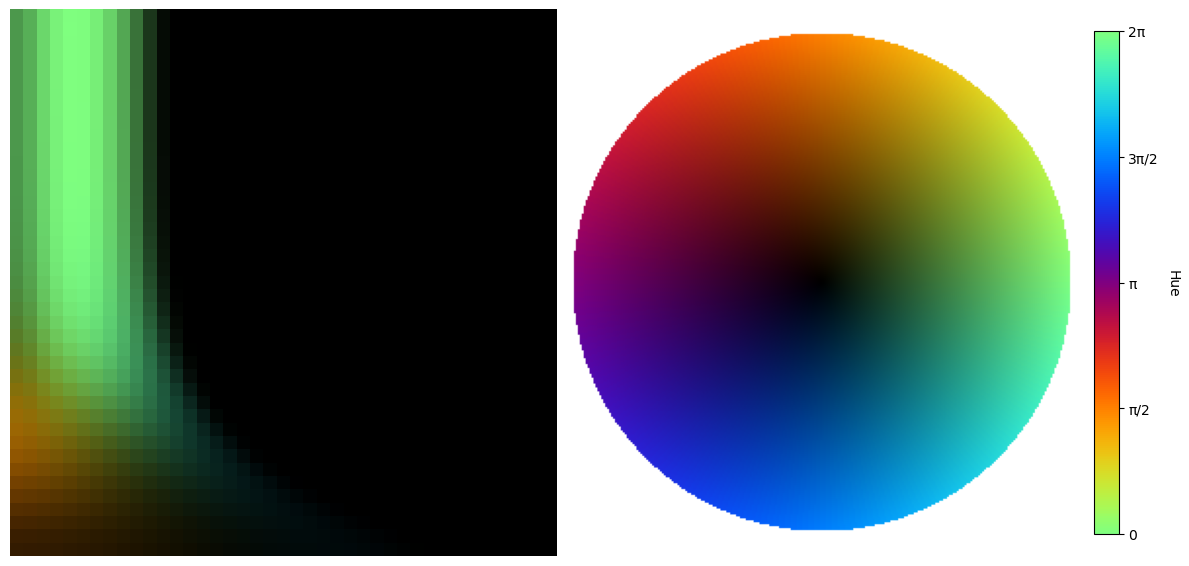

In [50]:
ripple_tilt, ripple_tilt_axis = calculate_surface_tilt(ripple_map, units='rad', show_results=True)
phplot((ripple_tilt_axis, ripple_tilt), Amp='raw', scale=True, subplot=True);

In [56]:
ripple_tilt.shape

(41, 41)

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


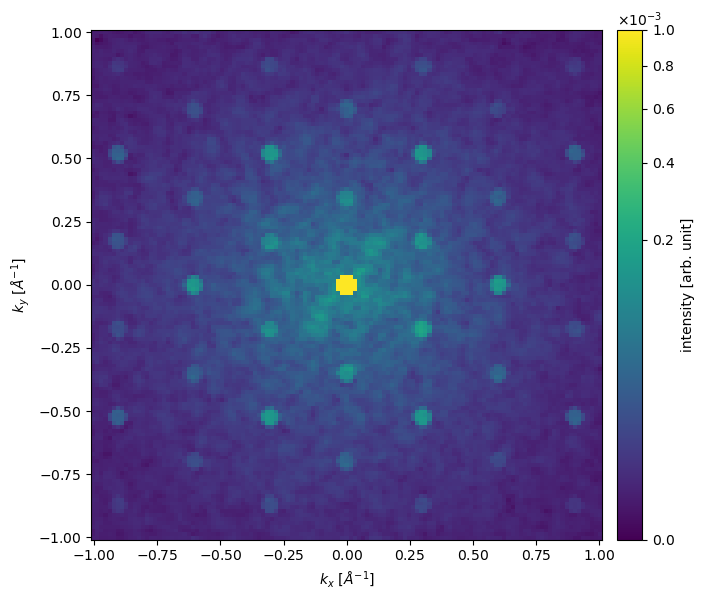

In [77]:
tilted_diffraction = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
                      theta_tilt=0, phi_rot=0, rotZ=0, units='rad', energy=80e3, 
                      semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=42, 
                      max_frequency=1, get_probe_info=False,show_model=False,
                      frozen_phonons=True, num_configs=8, sigmas=sigmas, seed=1000*int(np.random.random()), 
                      ensemble_mean=True)

tilted_diffraction.show(
                         explode=True,
                         power=0.33,
                         figsize=(10, 6),
                         cbar=True,
                        vmax=0.001
                         );



In [57]:
ky, kx = flat_pattern.array.shape
ny, nx = ripple_map.shape

# Get minimum dimension, use as resizing number
ksize = 

# Initialize simulated 4D dataset
ripple_dataset = np.zeros((ny, nx, ksize, ksize), dtype=np.float32)

for y in range(ny):
    for x in range(nx):
        
        theta, phi = (ripple_tilt[y, x], ripple_tilt_axis[y, x])
                
        tilted_diffraction = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
                              theta_tilt=theta, phi_rot=phi, rotZ=0, units='rad', energy=80e3, 
                              semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
                              sampling_probe=0.2, gpts=2**8.5, device='gpu', max_angle=42, 
                              max_frequency=1, get_probe_info=False,show_model=False,
                              frozen_phonons=True, num_configs=8, sigmas=sigmas, seed=1000*int(np.random.random()), 
                              ensemble_mean=True)
        
        # Convert to numpy array and define correct orientation
        diff_array = np.rot90(tilted_diffraction.array)
        
        # Resize to square matrix and add to 4D dataset
        ripple_dataset[y, x] = 

### 1.2. Preprocessed Data

If section **1.1** was skipped, then **do not** skip this section. Otherwise skip. 

In [ ]:
# Load preprocessed dataset
fname_processedData = 'ws2_wse2_superlattice_processed_data.npy'
ws2se2_superlattice = HyperData(np.load(fname_processedData))

In [27]:
"""[Optional] Run py4D-browser to visualize the aligned 4D dataset."""

import subprocess

np.save(fname_processedData, ws2se2_superlattice.data) # Save aligned dataset
command = ['py4DGUI', fname_processedData] 
result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

---

## 2. Denoising

### 2.1. Spatial Filters

### 2.2. Transform Domain Filters

### 2.3. Tensor Decomposition Filters

### 2.4. Supervised Machine Learning

Generate **training data** by simulating `N` diffraction patterns.

In [243]:
wse2_substrate_phonon = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
          theta_tilt=28, phi_rot=19, rotZ=24, units='deg', energy=80e3, 
          semiangle_cutoff=1.5, sampling_potential=0.2, slice_thickness=0.5,
          sampling_probe=0.2, gpts=2**8, device='gpu', max_angle=None, get_probe_info=False,show_model=False,
          frozen_phonons=True, num_configs=1, sigmas=sigmas, seed=1000*int(np.random.random()), ensemble_mean=True, auto_crop=False)

C:\Users\haloe\anaconda3\Lib\site-packages\abtem\core\grid.py:93: UserWarning: Overspecified grid, the provided sampling is ignored
  warnings.warn("Overspecified grid, the provided sampling is ignored")


In [244]:
wse2_substrate_phonon.is_lazy

True

In [342]:
import warnings
warnings.filterwarnings("ignore", message="Overspecified grid, the provided sampling is ignored")

In [363]:
# We define a function that will extract a random number between min_val and max_val
def rand_val(min_val, max_val):
    val_range = max_val - min_val
    return np.random.random()*val_range + min_val

output_path = "C:/Users/haloe/Documents/CodeWriting/4Denoise/"

# Number of noisy-clean pairs
N = 2

for i in range(N):  
    
    # Define random parameters within a range
    theta = rand_val(0,30)
    phi = rand_val(0, 360)
    z = rand_val(0, 360)
    conv_angle = rand_val(0.5, 2.5)
    pw = rand_val(8, 9)
    
    clean =  simulate_diff(wse2_lattice, theta_tilt=theta, phi_rot=phi, rotZ=z, units='deg', energy=80e3, 
              semiangle_cutoff=conv_angle, sampling_potential=0.2, slice_thickness=0.5,
              sampling_probe=0.2, gpts=2**pw, device='gpu', max_angle=None, get_probe_info=False,
              frozen_phonons=True,num_configs=10,seed=1000*int(np.random.random()),sigmas=0.3,ensemble_mean=True); # Frozen phonon arguments
    
    noisy = simulate_diff(atom_model=wse2_lattice, substrate=amorphous_SiN, interlayer_dist=2,vacuum=2,
                      theta_tilt=theta, phi_rot=phi, rotZ=z, units='deg', energy=80e3, 
                      semiangle_cutoff=conv_angle, sampling_potential=0.2, slice_thickness=0.5,
                      sampling_probe=0.2, gpts=2**pw, device='gpu', max_angle=None, 
                      get_probe_info=False,show_model=False,
                      frozen_phonons=True, num_configs=10, sigmas=sigmas, seed=1000*int(np.random.random()), 
                      ensemble_mean=True);
    
    # Format filename with leading zeros (e.g., flat_pattern_0001.zarr)
    formatted_clean = os.path.join(output_path, f"sim_clean_WSe2/clean_{i+1:04d}.zarr")
    formatted_noisy = os.path.join(output_path, f"sim_noisy_WSe2/noisy_{i+1:04d}.zarr")

    # Save the current flat_pattern
    clean.to_zarr(url=formatted_clean, compute=False, overwrite=True)
    noisy.to_zarr(url=formatted_noisy, compute=False, overwrite=True)

---

## 3. Strain Mapping